<a href="https://colab.research.google.com/github/Antonsen2/wildfire-ai/blob/colab-full-dataset/neural-networks/colab_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Imports

In [32]:
import os.path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [33]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-01-01 10:33:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-01 10:33:27 (82.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
RANDOM_SEED = 42

DATA_PATH = '/content/drive/MyDrive/full'  # Local or Drive path to the images
IMG_DIR = Path(DATA_PATH)

##### Data helper functions

In [36]:
def split_df(df: pd.DataFrame, cols: list, **kwargs) -> pd.DataFrame:
    df1 = pd.DataFrame()

    for k, v in kwargs.items():
        df2 = df.loc[df['Label'] == k][cols].sample(n=v)
        df1 = pd.concat([df1, df2])

    df1.index = range(len(df1))
    return df1

In [37]:
def train_model(pretrained_model: MobileNetV2, train_images, val_images) -> tuple:
    inputs = pretrained_model.input
    X = resize_and_rescale(inputs)

    X = Dense(256, activation='relu')(pretrained_model.output)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.2)(X)


    outputs = Dense(2, activation='softmax')(X)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback(
                'training_logs', 
                'fire_classification'
            ),
            checkpoint_callback,
        ]
    )

    return model, history

##### Plot functions

In [38]:
def plot_random_images(df: pd.DataFrame) -> None:
    random_index = np.random.randint(0, len(df), 16)
    fig, axes = plt.subplots(
        nrows=4,
        ncols=4,
        figsize=(10, 10),
        subplot_kw={'xticks': [], 'yticks': []}
    )

    for i, ax in enumerate(axes.flat):
        image = Image.open(df.Filepath[random_index[i]])
        ax.imshow(image)
        ax.set_title(df.Label[random_index[i]])

    plt.tight_layout()
    plt.show()

def plot_predictions(df: pd.DataFrame, preds: list) -> None:
    random_index = np.random.randint(0, len(df) - 1, 15)
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image = Image.open(df.Filepath.iloc[random_index[i]])
        ax.imshow(image)
        if df.Label.iloc[random_index[i]] == preds[random_index[i]]:
          color = 'green'
        else:
          color = 'red'
        ax.set_title(
            f'True: {df.Label.iloc[random_index[i]]}\nPredicted: {preds[random_index[i]]}',
            color=color
        )
    plt.show()
    plt.tight_layout()

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

    if savefig:
        fig.savefig("confusion_matrix.png")

In [39]:
walk_through_dir(DATA_PATH)

There are 3 directories and 0 images in '/content/drive/MyDrive/full'.
There are 0 directories and 2071 images in '/content/drive/MyDrive/full/fire'.
There are 0 directories and 2150 images in '/content/drive/MyDrive/full/satellite'.
There are 0 directories and 500 images in '/content/drive/MyDrive/full/nonfire'.


In [40]:
filepaths = list(IMG_DIR.glob(r'**/*.JPG')) + list(IMG_DIR.glob(r'**/*.jpg')) + list(IMG_DIR.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

Filepath    Label
0         /content/drive/MyDrive/full/fire/fire-837.jpg     fire
1        /content/drive/MyDrive/full/fire/fire-1095.jpg     fire
2         /content/drive/MyDrive/full/fire/fire-759.jpg     fire
3        /content/drive/MyDrive/full/fire/fire-1047.jpg     fire
4         /content/drive/MyDrive/full/fire/fire-821.jpg     fire
...                                                 ...      ...
4716  /content/drive/MyDrive/full/nonfire/forest-396...  nonfire
4717  /content/drive/MyDrive/full/nonfire/forest-401...  nonfire
4718  /content/drive/MyDrive/full/nonfire/forest-381...  nonfire
4719  /content/drive/MyDrive/full/nonfire/forest-458...  nonfire
4720  /content/drive/MyDrive/full/nonfire/forest-424...  nonfire

[4721 rows x 2 columns]

Split data into smaller datasets.
*   50-50% fire-no-fire
*   70-30% fire-no-fire
*   30-70% fire-no-fire



In [41]:
df_50_50 = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=250,
    nonfire=250
)
df_70_30 = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=350,
    nonfire=150
)
df_30_70 = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=150,
    nonfire=350
)

In [42]:
df_full = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=2071,
    nonfire=500
)

In [15]:
df_50_50

Filepath    Label
0       /content/drive/MyDrive/full/fire/fire-1115.jpg     fire
1        /content/drive/MyDrive/full/fire/fire-781.jpg     fire
2       /content/drive/MyDrive/full/fire/fire-1872.jpg     fire
3       /content/drive/MyDrive/full/fire/fire-1395.jpg     fire
4       /content/drive/MyDrive/full/fire/fire-2018.jpg     fire
..                                                 ...      ...
495  /content/drive/MyDrive/full/nonfire/forest-147...  nonfire
496  /content/drive/MyDrive/full/nonfire/forest-469...  nonfire
497  /content/drive/MyDrive/full/nonfire/forest-393...  nonfire
498  /content/drive/MyDrive/full/nonfire/forest-140...  nonfire
499  /content/drive/MyDrive/full/nonfire/forest-102...  nonfire

[500 rows x 2 columns]

In [16]:
df_70_30.loc[df_70_30['Label'] == 'nonfire']

Filepath    Label
350  /content/drive/MyDrive/full/nonfire/forest-115...  nonfire
351  /content/drive/MyDrive/full/nonfire/forest-239...  nonfire
352  /content/drive/MyDrive/full/nonfire/forest-220...  nonfire
353  /content/drive/MyDrive/full/nonfire/forest-339...  nonfire
354  /content/drive/MyDrive/full/nonfire/forest-468...  nonfire
..                                                 ...      ...
495  /content/drive/MyDrive/full/nonfire/forest-25.jpg  nonfire
496  /content/drive/MyDrive/full/nonfire/forest-112...  nonfire
497  /content/drive/MyDrive/full/nonfire/forest-416...  nonfire
498   /content/drive/MyDrive/full/nonfire/forest-6.jpg  nonfire
499  /content/drive/MyDrive/full/nonfire/forest-203...  nonfire

[150 rows x 2 columns]

##### Train 50-50

In [17]:
train_df, test_df = train_test_split(
    df_50_50, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [54]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=IMG_SIZE+ (3,),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [17]:
test_images

In [18]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [19]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20221231-173107
Epoch 1/100
10/10 [==============================] - 70s 7s/step - loss: 0.4997 - accuracy: 0.7719 - val_loss: 0.2189 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 0.2065 - accuracy: 0.9656 - val_loss: 0.0858 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 15s 2s/step - loss: 0.1069 - accuracy: 0.9781 - val_loss: 0.0455 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 16s 2s/step - loss: 0.0553 - accuracy: 0.9875 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 0.0464 - accuracy: 0.9875 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 0.0431 - accuracy: 0.9906 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 16s 2s/step - loss

In [20]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.02354
Test Accuracy:  99.00


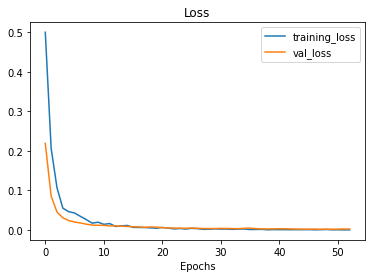

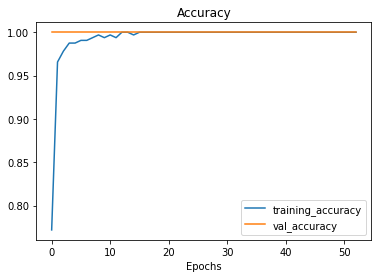

In [21]:
plot_loss_curves(history)

In [22]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

4/4 [==============================] - 4s 749ms/step
The first 5 predictions: ['nonfire', 'fire', 'nonfire', 'fire', 'fire']


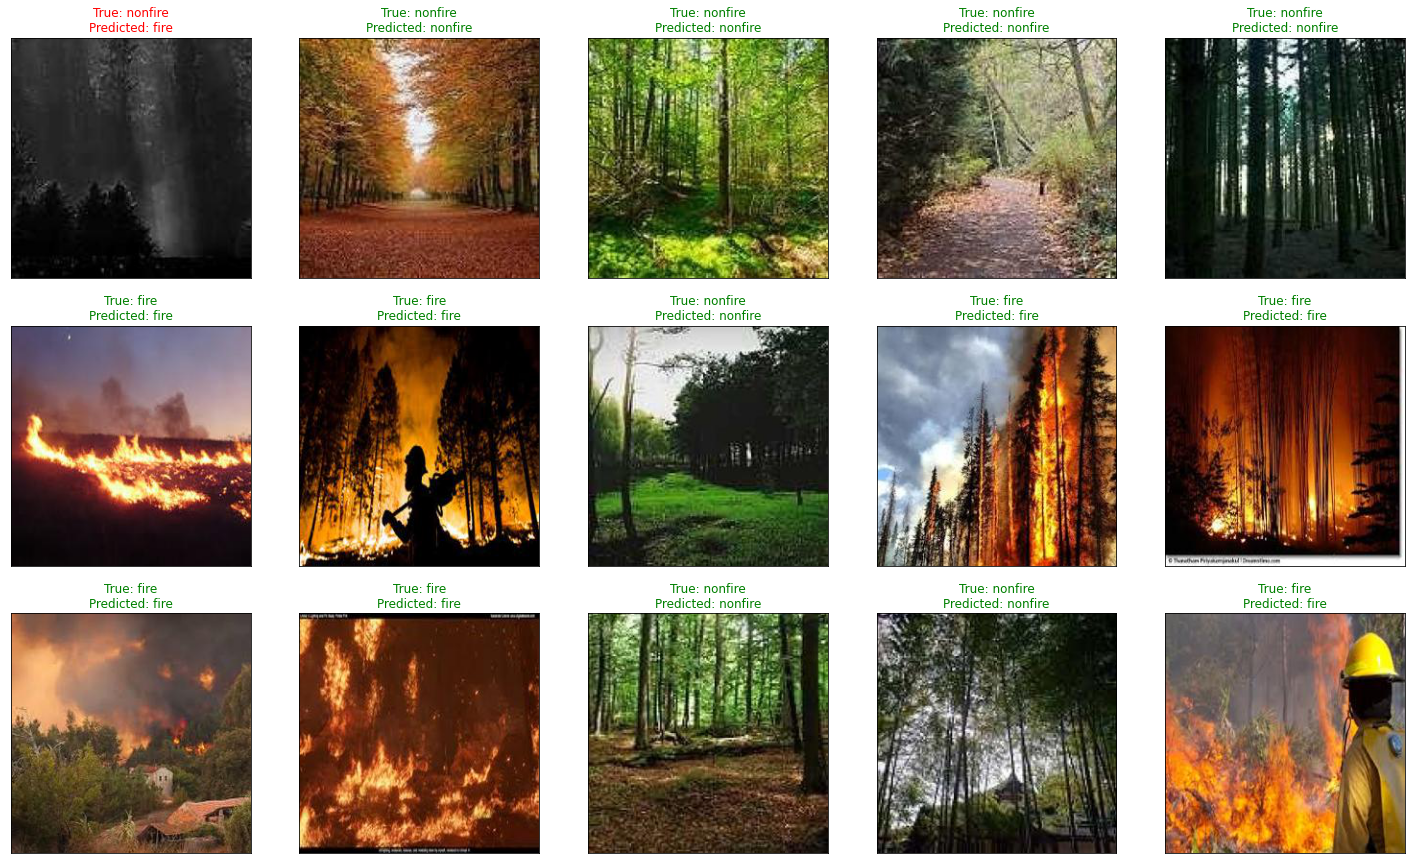

<Figure size 432x288 with 0 Axes>

In [23]:
plot_predictions(test_df, predictions)

In [24]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       0.98      1.00      0.99        46
     nonfire       1.00      0.98      0.99        54

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [65]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

precision    recall  f1-score  support
fire           1.000000  0.969697  0.984615    33.00
nonfire        0.985294  1.000000  0.992593    67.00
accuracy       0.990000  0.990000  0.990000     0.99
macro avg      0.992647  0.984848  0.988604   100.00
weighted avg   0.990147  0.990000  0.989960   100.00

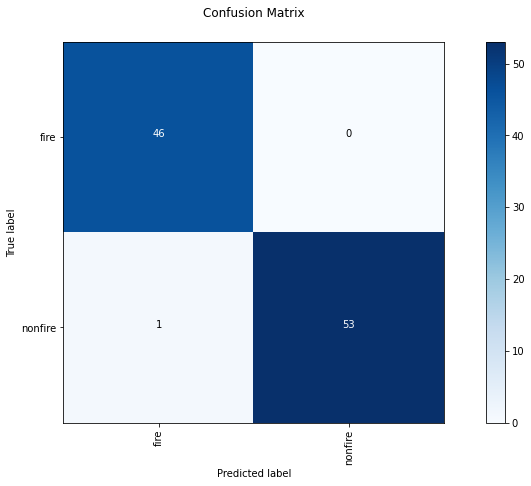

In [26]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [27]:
model.save('model_50-50.h5')

##### Train 70-30

In [28]:
train_df, test_df = train_test_split(
    df_70_30, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [29]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [31]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [32]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20221231-174916
Epoch 1/100
10/10 [==============================] - 55s 6s/step - loss: 0.4614 - accuracy: 0.7812 - val_loss: 0.1878 - val_accuracy: 0.9750
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 0.2066 - accuracy: 0.9375 - val_loss: 0.0877 - val_accuracy: 0.9875
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 0.1163 - accuracy: 0.9719 - val_loss: 0.0586 - val_accuracy: 0.9875
Epoch 4/100
10/10 [==============================] - 14s 1s/step - loss: 0.0743 - accuracy: 0.9844 - val_loss: 0.0443 - val_accuracy: 0.9875
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 0.0548 - accuracy: 0.9875 - val_loss: 0.0375 - val_accuracy: 0.9875
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 0.0479 - accuracy: 0.9875 - val_loss: 0.0311 - val_accuracy: 0.9875
Epoch 7/100
10/10 [==============================] - 17s 2s/step - loss

In [33]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.01490
Test Accuracy:  99.00


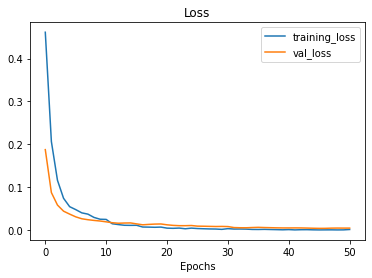

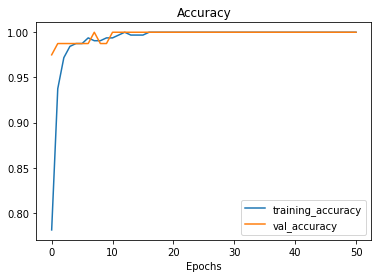

In [34]:
plot_loss_curves(history)

In [35]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

4/4 [==============================] - 5s 691ms/step
The first 5 predictions: ['nonfire', 'fire', 'nonfire', 'fire', 'fire']


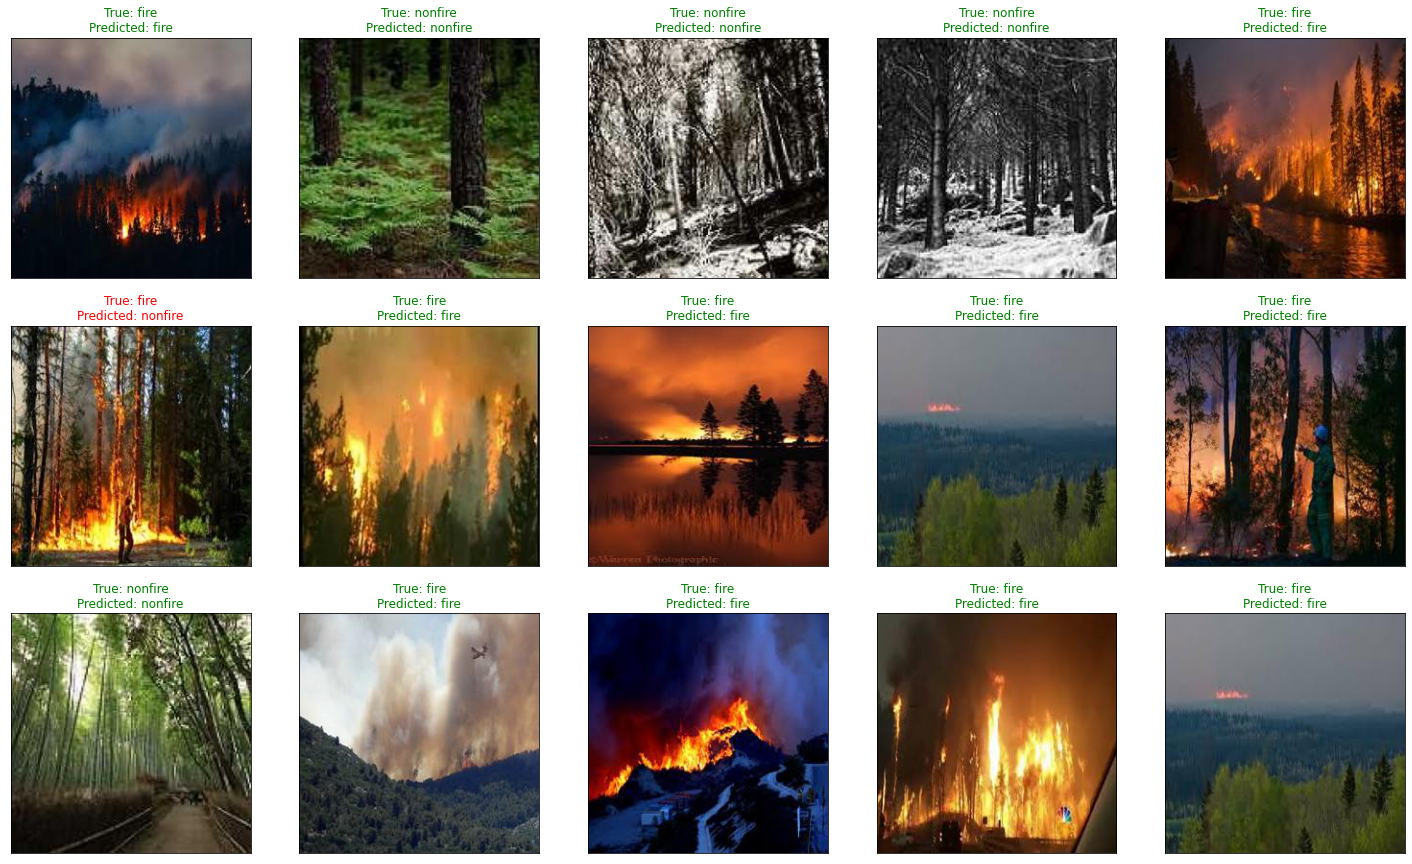

<Figure size 432x288 with 0 Axes>

In [36]:
plot_predictions(test_df, predictions)

In [37]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       1.00      0.98      0.99        64
     nonfire       0.97      1.00      0.99        36

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [38]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

precision    recall  f1-score  support
fire           1.000000  0.984375  0.992126    64.00
nonfire        0.972973  1.000000  0.986301    36.00
accuracy       0.990000  0.990000  0.990000     0.99
macro avg      0.986486  0.992188  0.989214   100.00
weighted avg   0.990270  0.990000  0.990029   100.00

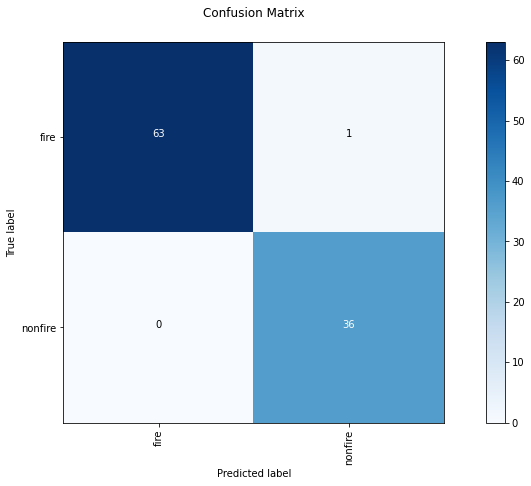

In [39]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [40]:
model.save('model_70-30.h5')

##### Train 30-70

In [41]:
train_df, test_df = train_test_split(
    df_30_70, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [42]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 320 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [44]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [45]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20221231-180544
Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 0.6551 - accuracy: 0.6187 - val_loss: 0.4667 - val_accuracy: 0.7000
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 0.2930 - accuracy: 0.8687 - val_loss: 0.2016 - val_accuracy: 0.9500
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 0.1448 - accuracy: 0.9688 - val_loss: 0.0813 - val_accuracy: 0.9875
Epoch 4/100
10/10 [==============================] - 13s 1s/step - loss: 0.0834 - accuracy: 0.9937 - val_loss: 0.0453 - val_accuracy: 0.9875
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 0.0616 - accuracy: 0.9906 - val_loss: 0.0310 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 0.0499 - accuracy: 0.9906 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 16s 2s/step - loss

In [46]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.01069
Test Accuracy:  99.00


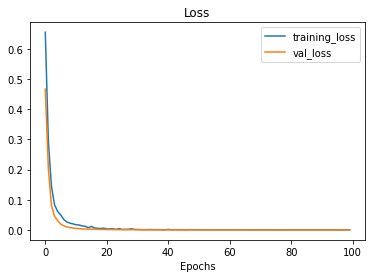

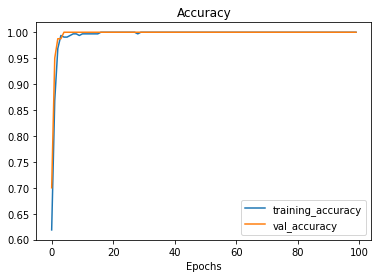

In [47]:
plot_loss_curves(history)

In [48]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

4/4 [==============================] - 4s 713ms/step
The first 5 predictions: ['nonfire', 'nonfire', 'nonfire', 'nonfire', 'fire']


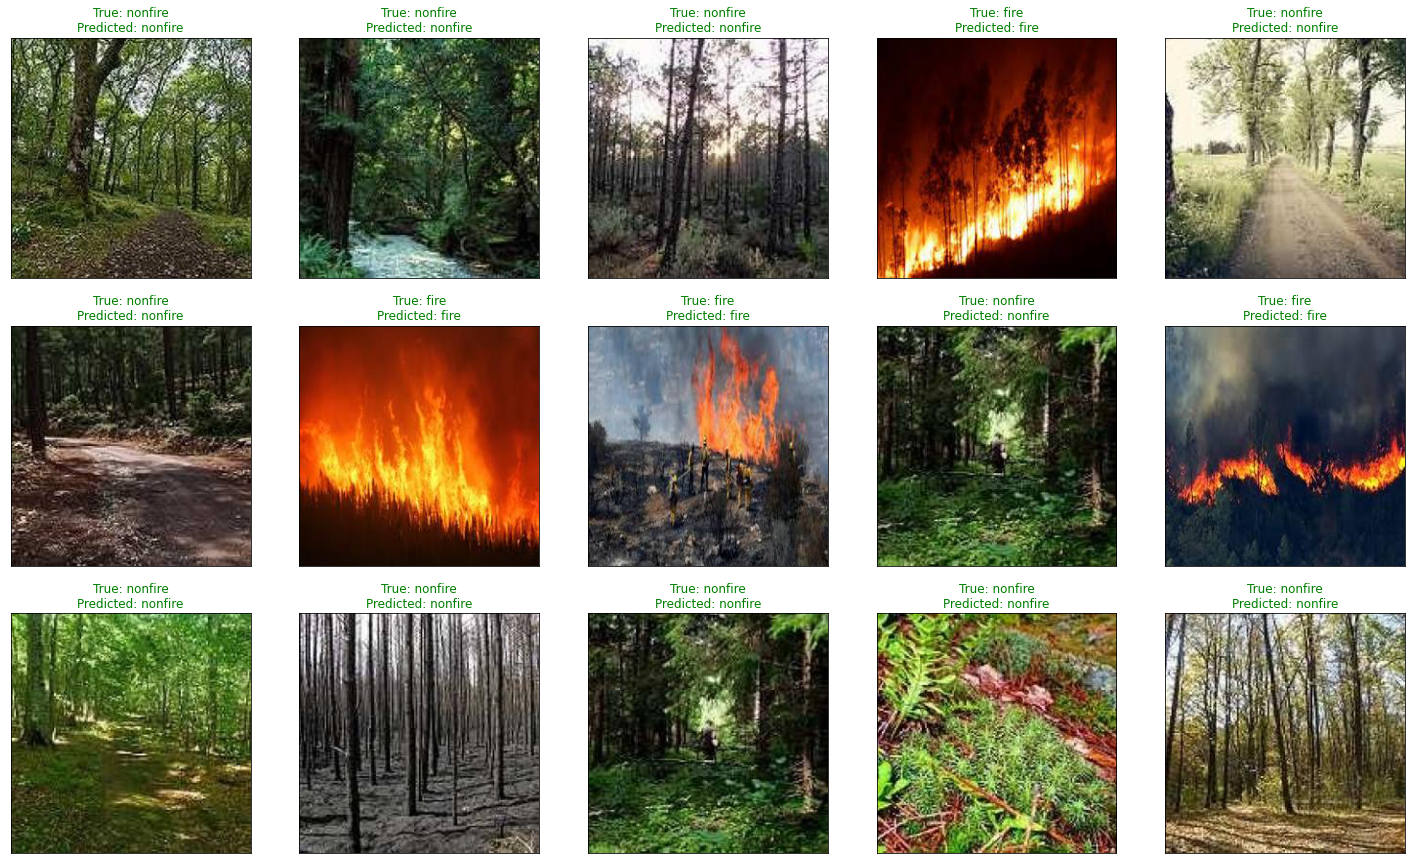

<Figure size 432x288 with 0 Axes>

In [49]:
plot_predictions(test_df, predictions)

In [50]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       1.00      0.97      0.98        33
     nonfire       0.99      1.00      0.99        67

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



In [51]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

precision    recall  f1-score  support
fire           1.000000  0.969697  0.984615    33.00
nonfire        0.985294  1.000000  0.992593    67.00
accuracy       0.990000  0.990000  0.990000     0.99
macro avg      0.992647  0.984848  0.988604   100.00
weighted avg   0.990147  0.990000  0.989960   100.00

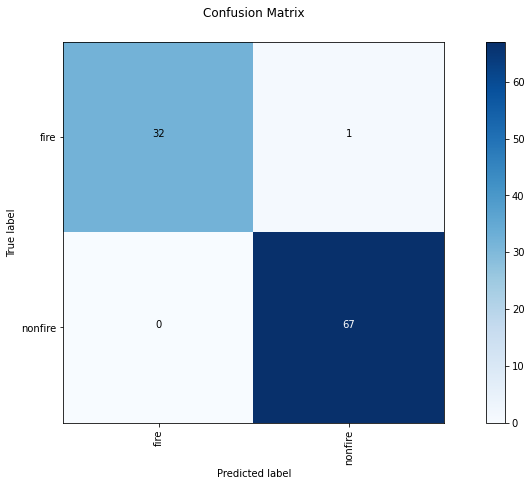

In [52]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [53]:
model.save('model_30-70.h5')

##### Train Full Dataset

In [17]:
train_df, test_df = train_test_split(
    df_full, test_size=0.2, shuffle=True, random_state=42
)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1645 validated image filenames belonging to 2 classes.
Found 411 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [21]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20230101-085109
Epoch 1/100
52/52 [==============================] - 744s 14s/step - loss: 0.1911 - accuracy: 0.9155 - val_loss: 0.0376 - val_accuracy: 0.9903
Epoch 2/100
52/52 [==============================] - 49s 935ms/step - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.0220 - val_accuracy: 0.9951
Epoch 3/100
52/52 [==============================] - 49s 941ms/step - loss: 0.0273 - accuracy: 0.9897 - val_loss: 0.0162 - val_accuracy: 0.9951
Epoch 4/100
52/52 [==============================] - 48s 930ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0130 - val_accuracy: 0.9951
Epoch 5/100
52/52 [==============================] - 50s 970ms/step - loss: 0.0130 - accuracy: 0.9976 - val_loss: 0.0106 - val_accuracy: 0.9951
Epoch 6/100
52/52 [==============================] - 49s 938ms/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.0088 - val_accuracy: 0.9976
Epoch 7/100
52/52 [==============================] - 4

In [22]:
results = model.evaluate(test_images, verbose=0)

print(f'Test Loss: {results[0] : .5f}')
print(f'Test Accuracy: {results[1] * 100 : .2f}')

Test Loss:  0.00365
Test Accuracy:  99.81


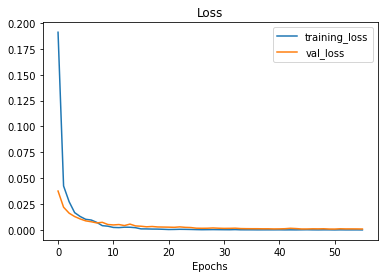

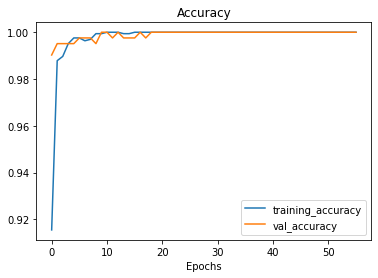

In [23]:
plot_loss_curves(history)

In [24]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

print(f'The first 5 predictions: {predictions[:5]}')

17/17 [==============================] - 13s 705ms/step
The first 5 predictions: ['fire', 'nonfire', 'nonfire', 'fire', 'fire']


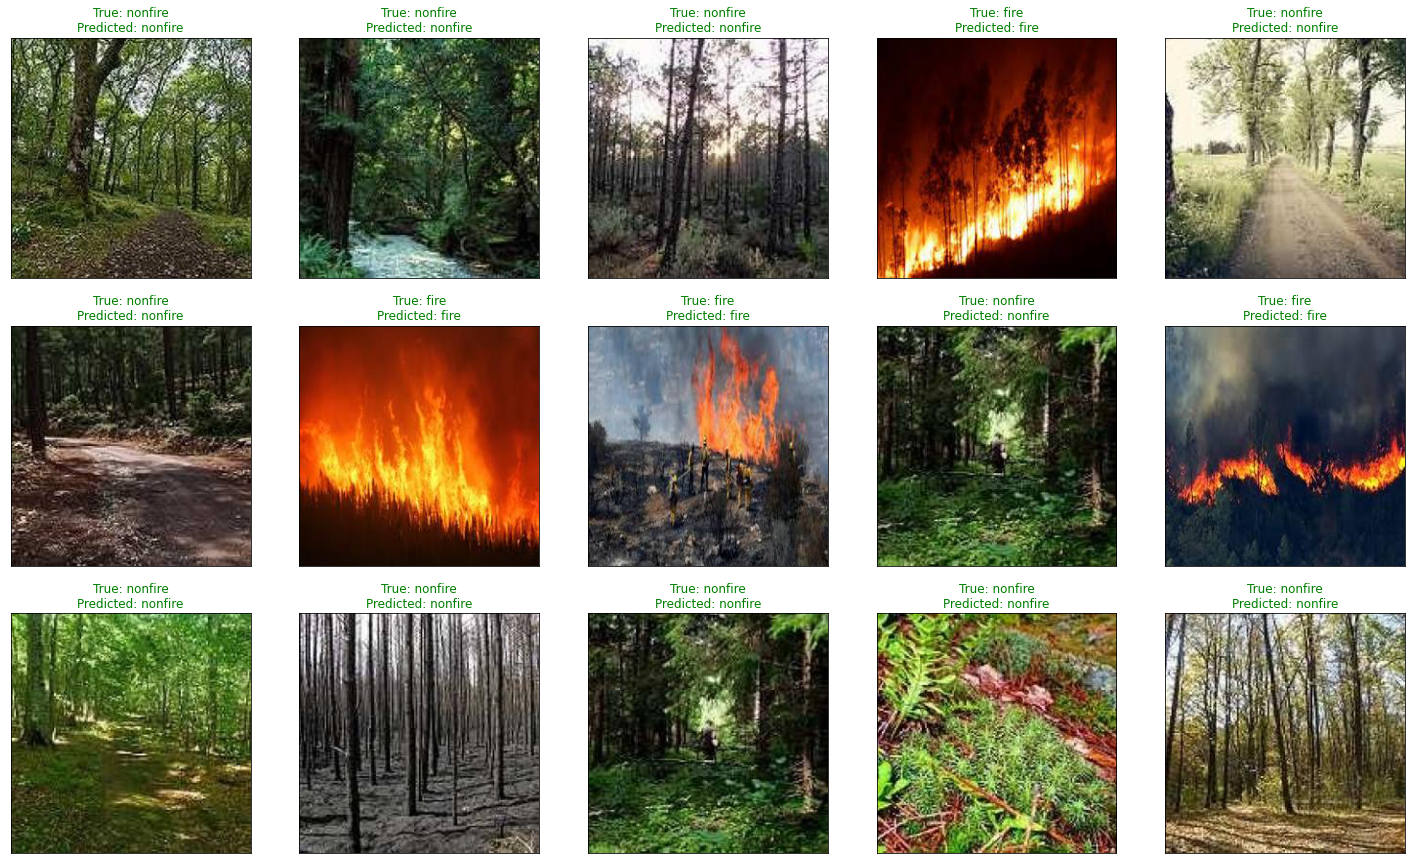

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_predictions(test_df, predictions)

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        fire       1.00      1.00      1.00       421
     nonfire       0.99      1.00      0.99        94

    accuracy                           1.00       515
   macro avg       0.99      1.00      1.00       515
weighted avg       1.00      1.00      1.00       515



In [26]:
report = classification_report(y_test, predictions, output_dict=True)
precision_df = pd.DataFrame(report).transpose()
precision_df

precision    recall  f1-score     support
fire           1.000000  0.997625  0.998811  421.000000
nonfire        0.989474  1.000000  0.994709   94.000000
accuracy       0.998058  0.998058  0.998058    0.998058
macro avg      0.994737  0.998812  0.996760  515.000000
weighted avg   0.998079  0.998058  0.998062  515.000000

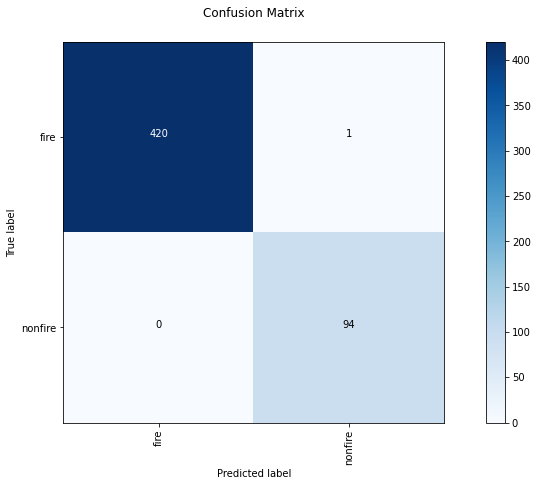

In [27]:
make_confusion_matrix(y_test, predictions, list(labels.values()))

In [28]:
model.save('model_full.h5')